<a href="https://colab.research.google.com/github/minjeon99/ESAA-10th-OB/blob/Week1/w1_mon_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. 분류**

## **3.1 MNIST**

In [ ]:
import numpy as np

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**딕셔너리 구조**
- DESCR: 데이터셋 설명
- data: (열-샘플), (특성-열)로 구성된 배열
- target: 레이블 배열

In [ ]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


- 70,000개 샘플 이미지
- 784개 특성: 28x28 픽셀
  - 각 특성: 0(흰색)~255(검은색)까지의 픽셀 강도

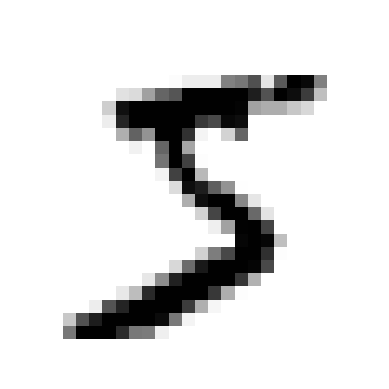

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

- 숫자 5로 보이는 이미지의 실제 레이블 확인

In [ ]:
y[0]

'5'

- 레이블이 문자열 -> 정수로 변환

In [ ]:
y = y.astype(np.uint8)

- 데이터 자세히 조사하기 전, 테스트 세트 만들어서 분리!
  - 훈련 세트(앞쪽 60,000개)
  - 테스트 세트(뒤쪽 10,000개)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 훈련 세트는 이미 섞여 있는 상태 => 모든 교차 검증 폴드 비슷해짐
  - 하나의 폴드라도 특정 숫자 누락되면 안 됨
  - 학습 알고리즘 종류에 따라, 훈련 샘플 순서에 민감해서 비슷한 샘플이 연이어 나타나면 성능 나빠짐 (: 대표적으로 SGD)
    - 시계열 데이터에서는 섞으면 X

  => 데이터셋 섞어서 문제 방지

## **3.2 이진 분류기 훈련**

- 문제 단순화 -> 하나의 숫자(5)만 식별
- 5-감지기: 2개의 클래스 구분하는 이진 분류기
  - '5'
  - '5 아님'

In [ ]:
# target vector 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**확률적 경사 하강법(SGD)**
- `SGDClassifier` 클래스
- 매우 큰 데이터셋을 효율적으로 처리하는 장점
  - 한 번에 하나씩 훈련 샘플을 독립적으로 처리 (=> 온라인 학습에 적합)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

- SGDClassifier는 훈련 시 무작위성 사용(=> '확률적')

  => random_state 지정하여 결과 재현

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## **3.3 성능 측정**

### **3.3.1 교차 검증을 사용한 정확도 측정**

- 3 fold 교차 검증으로 SGDClassifier 모델 평가

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상

In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만들어 비교

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self

  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- 정확도 90% 이상
  - 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측해도 정확도 90%
- **불균형 데이터셋**에서 분류기의 성능 측정 지표로 정확도를 선호하지 않는 이유

### **3.3.2 오차 행렬**

- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함
  - **테스트 세트**로 예측을 만들 수 있지만, **여기서 사용하면 X**
- `cross_val_predict()`: k-fold 교차 검증 수행 -> 평가 점수 반환 X, 각 테스트 폴드에서 얻은 예측 반환

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행: 실제 클래스
- 열: 예측한 클래스
  - 1행: negative class = '5 아님'
    - 1열: true negative = '5 아님'으로 정확히 분류
    - 2열: false positive = '5'라고 잘못 분류
  - 2행: positive class = '5'
    - 1열: false negative = '5 아님'으로 잘못 분류
    - 2열: true positive = '5'라고 정확히 분류


In [ ]:
# 완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 주대각선만 0이 아닌 값

오차 행렬의 많은 정보보다 요약된 지표가 필요할 경우
- 정밀도(precision): 양성 예측의 정확도
  - $정밀도=\frac{TP}{TP + FP}$
- 재현율(recall)=민감도(sensitivitiy)=진양성 비율(TPR=true positive rate): 분류기가 정확하게 감지한 양성 샘플의 비율
  - $재현율=\frac{TP}{TP+FN}$

  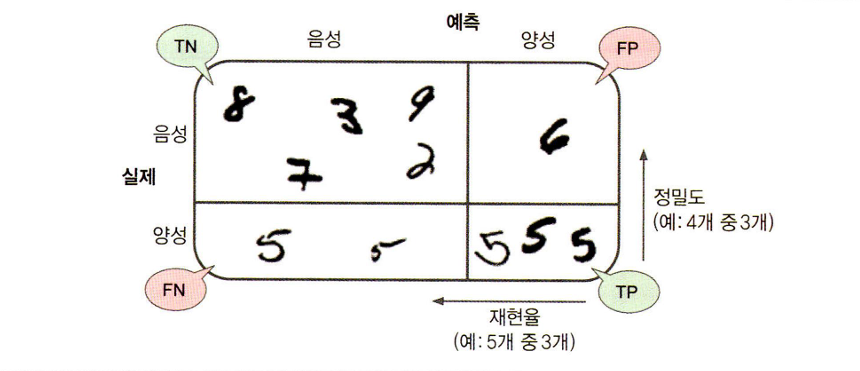

### **3.3.3 정밀도와 재현율**

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- 5로 판별된 이미지 중 83.7%만 정확함
- 전체 숫자 5에서 65.1%만 감지

- F1 score: 정밀도와 재현율의 조화 평균(harmonic mean)
  - $F_1=\frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}}=\frac{TP}{TP+\frac{FN + FP}{2}}$
  - 정밀도와 재현율을 하나의 숫자로 만듦
  - 두 분류기 비교할 때 편리

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서 높은 F1 score
  - 상황에 따라 정밀도나 재현율이 더 중요할 수도 있음
    - 정밀도가 중요한 경우: 어린아이에게 안전한 동영상을 선별하는 분류기
    - 재현율이 중요한 경우: 감시 카메라를 통해 좀도둑을 잡아내는 분류기
- **정밀도/재현율 트레이드오프**
  - 정밀도와 재현율 모두를 얻을 수는 없음
  - 하나를 높이면 하나가 감소하는 관계

### **3.3.4 정밀도/재현율 트레이드오프**

- SGDClassifier의 분류 알고리즘
  - 결정 함수(decision function)을 사용하여 각 샘플의 점수 계산
  - 해당 점수가 임곗값보다 크면 양성, 작으면 음성 클래스에 할당

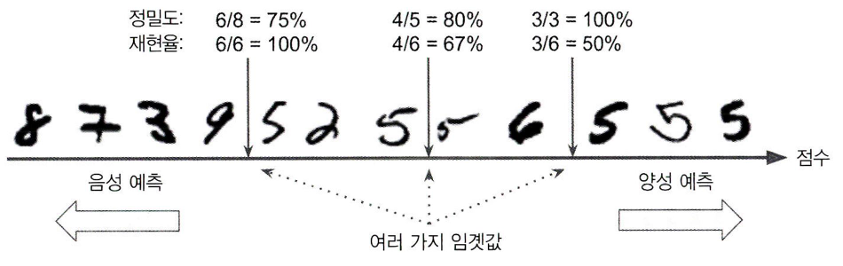
- 결정 임곗값(decision threshold)에 따라 정밀도/재현율 변화
  - 임곗값 높아지면 정밀도 증가, 재현율 감소
  - 임곗값 낮아지면 재현율 증가, 정밀도 감소

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 임곗값이 0이므로 predict() 메서드와 같은 결과(True) 반환

In [ ]:
# 임곗값 높아질 경우
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 재현율 감소
  - 실제 숫자 5 이미지 // 임곗값을 8000으로 높여서 분류기가 감지하지 못함

**[ 적절한 임곗값 설정 ]**
  - `cross_val_predict()` 함수를 사용해 모든 샘플의 점수 구하기
    - 예측 결과 (X), 결정 점수(O) 반환
  - `precision_recall_curve()` 함수를 사용해 모든 임곗값에 대한 정밀도, 재현율 계산

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

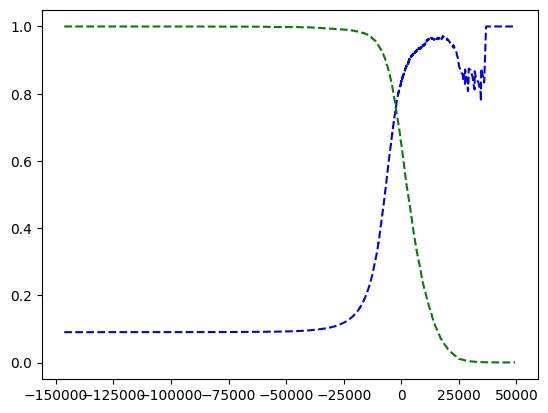

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

또 다른 방법
- 재현율에 대한 정밀도 곡선 그리기

  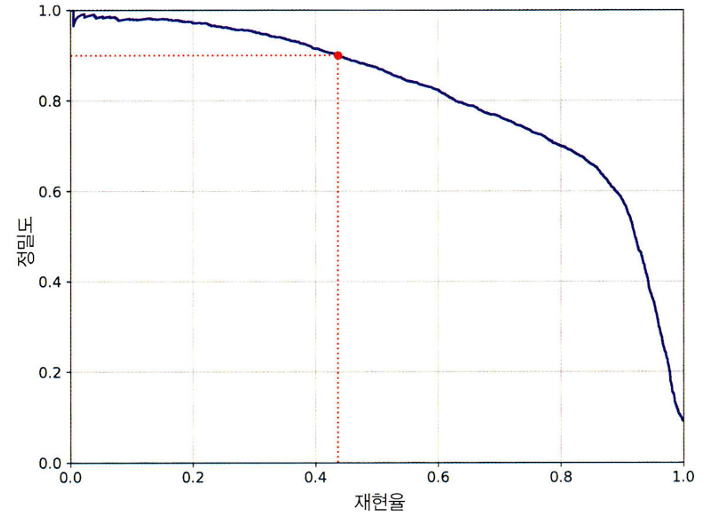

- 재현율 80% 근처에서 정밀도 급격하게 감소
  - 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 (예: 60% 정도)

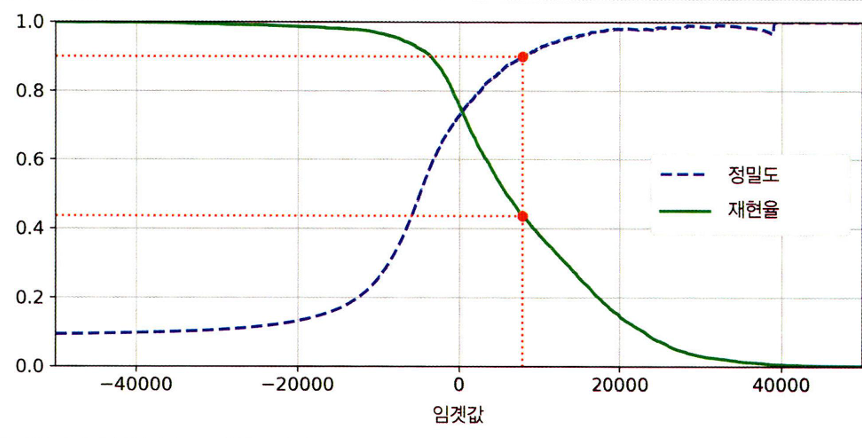
- 정밀도 90% 달성이 목표 -> 임곗값이 약 8,000

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### **3.3.5 ROC 곡선**

- 수신기 조작 특성(ROC) 곡선: FPR에 대한 TPR 곡선
  - TNR: 특이도
  - 민감도(재현율)에 대한 1-특이도

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

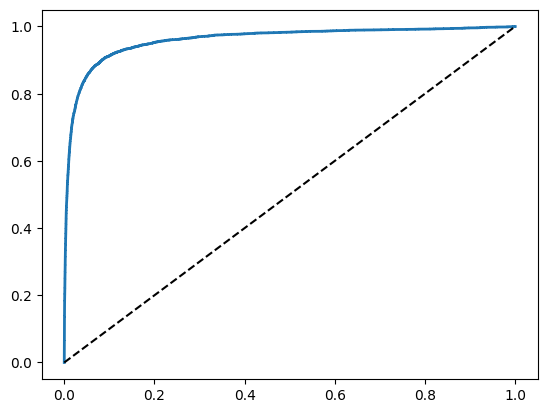

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)

- 재현율(TPR)이 높을수록 거짓 양성(FPR) 증가
- 점선: 완전한 랜덤 분류기의 ROC 곡선
  - 좋은 분류기는 점선에서 멀리 떨어져 있어야 함(왼쪽 위 모서리)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- AUC(곡선 아래의 면적) 측정 -> 분류기 비교
  - 완벽한 분류기: ROC의 AUC = 1
  - 완전한 랜덤 분류기=0.5

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교
  - RandomForestClassifier에는 `decision_function()` 없음 -> `predict_proba()` 메서드 이용

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

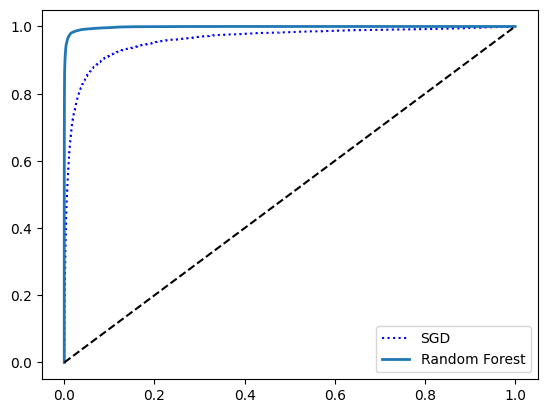

In [ ]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

- RandomForestClassifier의 ROC 곡선이 더 왼쪽 위 모서리에 가까움
  - SGDClassifier보다 좋은 성능

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## **3.4 다중 분류**

- 다중 분류기(다항 분류기): 둘 이상의 클래스를 구분
  - SGD, 랜덤 포레스트, 나이브 베이즈 등: 여러 개의 클래스 처리
  - 로지스틱 회귀, SVM 등: 이진 분류만 가능
- 여러 개의 이진 분류기를 사용해 다중 클래스 분류하는 기법도 있음
  - 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9) 훈련

    -> 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
    - OvR(one-versus-the-rest), OvA(one-versus-all) 전략
  - 0과 1 구별, 0과 2 구별, 1과 2 구별 ... 각 숫자 조합마다 이진 분류기 훈련
    - OvO(one-versus-one) 전략
    - N개의 클래스 -> N x (N-1)/2 개 필요
  - OvO 장점: 각 분류기 훈련에 구별할 두 클래스에 해당하는 샘플만 필요
    - SVM과 같은 일부 알고리즘은 훈련세트 크기에 민감 => 작은 훈련 세트에서 많은 분류기 훈련이 더 빠름
    - 대부분의 이진 분류 알고리즘에서는 OvR 선호
  - 다중 클래스 분류 작업에 이진 분류 알고리즘 선택 시 사이킷런이 알고리즘에 따라 자동적으로 OvR/OvO 실행

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아닌 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 0~9까지의 원래 타깃 클래스(y_train)을 사용해 SVC 훈련
- 예측 1개 생성 (정답!)
- 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기 훈련 -> 각각의 결정 점수 얻어 가장 높은 클래스 선택

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

- 클래스 5: 가장 높은 점수

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

- `OneVsOneClassifier`, `OneVsRestClassifier`: OvO나 OvR 사용하도록 강제

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**

실제 프로젝트라면 여러 모델을 시도하겠지만, 가능성 높은 모델을 하나 찾았다고 가정하고 성능을 향상시킬 방법 알아보기 => 에러의 종류 분석
1. 오차 행렬

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

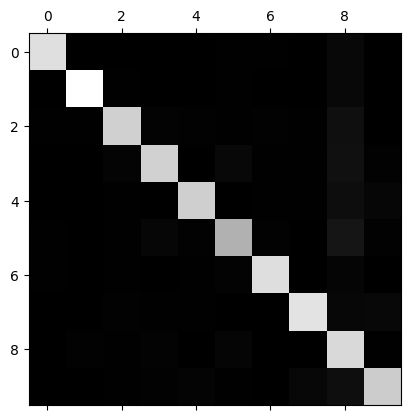

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

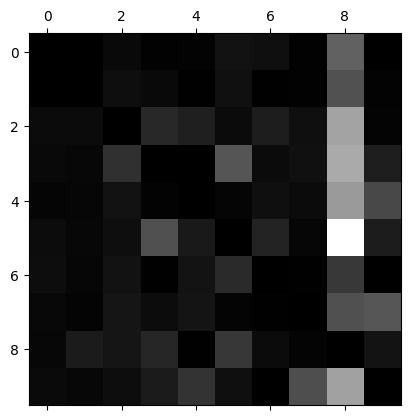

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [ ]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

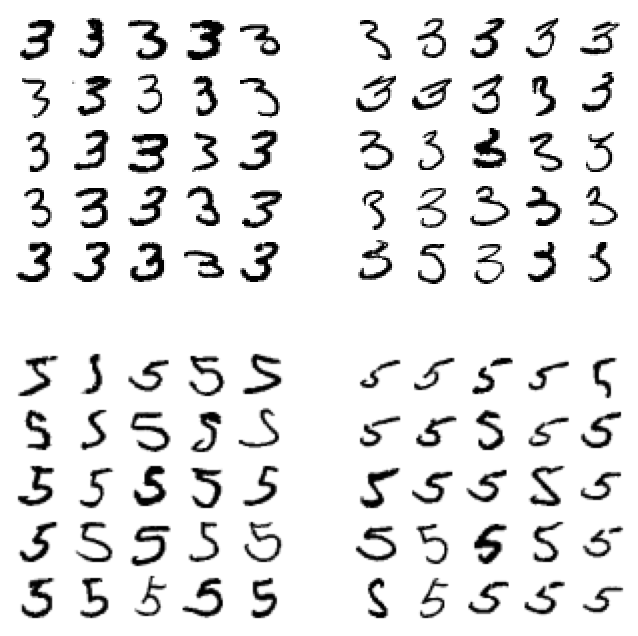

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

## **3.6. 다중 레이블 분류**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## **3.7 다중 출력 분류**

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

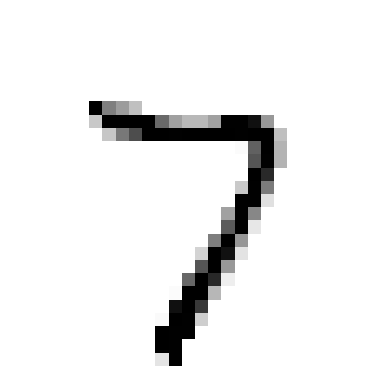

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)